In [1]:
SUBJECT = 1
BASE_DIR = "/tmp/akshett.jindal"
MODEL_ID = "Salesforce/instructblip-vicuna-7b"

In [2]:
MODEL_NAME = MODEL_ID.replace("/", "_").replace(" ", "_")

In [3]:
import os

EXP_DESIGN_FPATH = os.path.join(BASE_DIR, "nsd_expdesign.mat")

In [4]:
OUTPUT_DIR = os.path.join(BASE_DIR, "trained_models", MODEL_NAME)

In [5]:
import glob

IMAGE_EMBEDDINGS_DIR = os.path.join(
    BASE_DIR,
    "image_embeddings",
    MODEL_NAME,
    f"subject_{SUBJECT:02}",
    "batch_*.pkl",
)

batch_paths = sorted(
    glob.glob(IMAGE_EMBEDDINGS_DIR, recursive=True),
    key=lambda i: int(i.split('_')[-1].split('.')[0]),
)

In [6]:
import pickle

VISION_HIDDEN_STATES = {}
QFORMER_HIDDEN_STATES = {}

VISION_LAYERS_COUNT = 0
QFORMER_LAYERS_COUNT = 0

for batch_filepath in batch_paths:

    with open(batch_filepath, "rb") as batch_file:
        batches = pickle.load(batch_file)

    for batch in batches:
        vision_hs = batch['vision_hidden_states']
        qformer_hs = batch['qformer_hidden_states']

        for image_num, image_id in enumerate(batch['image_ids']):
            vhs = tuple(hs[image_num] for hs in vision_hs)
            qhs = tuple(hs[image_num] for hs in qformer_hs)

            VISION_LAYERS_COUNT = len(vhs)
            QFORMER_LAYERS_COUNT = len(qhs)

            VISION_HIDDEN_STATES[image_id] = vhs
            QFORMER_HIDDEN_STATES[image_id] = qhs

    del batches

In [7]:
VISION_LAYERS_COUNT, QFORMER_LAYERS_COUNT

(40, 13)

In [8]:
min(VISION_HIDDEN_STATES.keys()), max(VISION_HIDDEN_STATES.keys())

(14, 73000)

In [9]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cuda')

In [20]:
from nsd_dataset import mind_eye_nsd_utils as menutils

(
    session_data,
    (
        trn_stim_ordering, trn_voxel_data,
        val_stim_ordering, val_voxel_data
    )
) = menutils.get_split_data(BASE_DIR, SUBJECT)

  0%|          | 0/40 [00:00<?, ?it/s]

Total number of voxels = 15724


In [21]:
import numpy as np

np.random.seed(42)

tst_indices = np.random.choice(
    np.arange(trn_stim_ordering.shape[0]),
    size=val_stim_ordering.shape[0],
    replace=False,
)

tst_indices.shape, tst_indices.min(), tst_indices.max()

((3000,), 6, 26964)

In [22]:
trn_mask = np.ones(trn_stim_ordering.shape[0], dtype=bool)
trn_mask[tst_indices] = False

train_stim_ordering = np.copy(trn_stim_ordering[trn_mask])
train_voxel_data = np.copy(trn_voxel_data[trn_mask])

tst_stim_ordering = np.copy(trn_stim_ordering[tst_indices])
tst_voxel_data = np.copy(trn_voxel_data[tst_indices])

del trn_stim_ordering, trn_voxel_data

trn_stim_ordering = train_stim_ordering
trn_voxel_data = train_voxel_data

In [23]:
print(f"{session_data.shape = }")
print(f"{trn_stim_ordering.shape = }")
print(f"{trn_voxel_data.shape = }")
print(f"{tst_stim_ordering.shape = }")
print(f"{tst_voxel_data.shape = }")
print(f"{val_stim_ordering.shape = }")
print(f"{val_voxel_data.shape = }")

session_data.shape = (30000, 15724)
trn_stim_ordering.shape = (24000,)
trn_voxel_data.shape = (24000, 15724)
tst_stim_ordering.shape = (3000,)
tst_voxel_data.shape = (3000, 15724)
val_stim_ordering.shape = (3000,)
val_voxel_data.shape = (3000, 15724)


In [25]:
exp_design = menutils.load_exp_design_file(BASE_DIR)

trial_images = exp_design["subjectim"]

In [26]:
trn_images = trial_images[SUBJECT-1, trn_stim_ordering] - 1
val_images = trial_images[SUBJECT-1, val_stim_ordering] - 1
tst_images = trial_images[SUBJECT-1, tst_stim_ordering] - 1

trn_images.shape, trn_images.min(), trn_images.max()

((24000,), 13, 72999)

In [27]:
import numpy as np
from sklearn.linear_model import LinearRegression
from tqdm.auto import tqdm

In [35]:
VISION_MODELS = []

for layer_num in tqdm(range(VISION_LAYERS_COUNT)):
    trn_hs = np.array([
        VISION_HIDDEN_STATES[image_id+1][layer_num]
        for image_id in trn_images
    ])
    val_hs = np.array([
        VISION_HIDDEN_STATES[image_id+1][layer_num]
        for image_id in val_images
    ])
    tst_hs = np.array([
        VISION_HIDDEN_STATES[image_id+1][layer_num]
        for image_id in tst_images
    ])

    reg = LinearRegression(copy_X=True).fit(trn_hs, trn_voxel_data)
    # print(f"{reg.coef_ = }, {reg.intercept_ = }")

    # trn_voxel_data_pred = reg.predict(trn_hs)
    # val_voxel_data_pred = reg.predict(val_hs)
    # tst_voxel_data_pred = reg.predict(tst_hs)
    # print(f"{reg.score(val_hs, val_voxel_data_pred) = }")
    trn_score = reg.score(trn_hs, trn_voxel_data)
    val_score = reg.score(val_hs, val_voxel_data)
    tst_score = reg.score(tst_hs, tst_voxel_data)

    print(f"{trn_score = }, {val_score = }, {tst_score = }")

    VISION_MODELS.append({
        "model": reg,
        "trn_score": trn_score,
        "val_score": val_score,
        "tst_score": tst_score,
    })

  0%|          | 0/40 [00:00<?, ?it/s]

trn_score = 0.028682754780758445, val_score = -0.03779669159937311, tst_score = -0.020642353123676793
trn_score = 0.1108947503981467, val_score = -0.038034949606357255, tst_score = -0.007850153402664399
trn_score = 0.1208771683883554, val_score = -0.02266480887861278, tst_score = 0.0044971426208716015
trn_score = 0.12532272458102428, val_score = -0.01534778702239022, tst_score = 0.009413220471857544
trn_score = 0.1272294593741032, val_score = -0.011754470586402003, tst_score = 0.012283025455522342
trn_score = 0.12861114377253444, val_score = -0.011468425748263988, tst_score = 0.014214974616583559
trn_score = 0.13172437365719653, val_score = -0.010363712811804102, tst_score = 0.016678135716765408
trn_score = 0.13283024040366442, val_score = -0.006138949696787477, tst_score = 0.0182851654060913
trn_score = 0.13442416211037245, val_score = -0.0036239039983349715, tst_score = 0.02106552072123469
trn_score = 0.1359684154151906, val_score = -0.001238245408761083, tst_score = 0.02272719250097

In [36]:
import os

VISION_OUTPUT_DIR = os.path.join(OUTPUT_DIR, "vision_models")

os.makedirs(VISION_OUTPUT_DIR, exist_ok=True)

for layer_num, vision_model in tqdm(enumerate(VISION_MODELS), total=VISION_LAYERS_COUNT):
    model_path = os.path.join(VISION_OUTPUT_DIR, f"vision_model_{layer_num:03}.pkl")

    with open(model_path, "wb") as f:
        pickle.dump(vision_model, f)

  0%|          | 0/40 [00:00<?, ?it/s]

In [37]:
QFORMER_MODELS = []

for layer_num in tqdm(range(QFORMER_LAYERS_COUNT)):
    trn_hs = np.array([
        QFORMER_HIDDEN_STATES[image_id+1][layer_num]
        for image_id in trn_images
    ])
    val_hs = np.array([
        QFORMER_HIDDEN_STATES[image_id+1][layer_num]
        for image_id in val_images
    ])
    tst_hs = np.array([
        QFORMER_HIDDEN_STATES[image_id+1][layer_num]
        for image_id in tst_images
    ])

    reg = LinearRegression(copy_X=True).fit(trn_hs, trn_voxel_data)
    # print(f"{reg.coef_ = }, {reg.intercept_ = }")

    # trn_voxel_data_pred = reg.predict(trn_hs)
    # val_voxel_data_pred = reg.predict(val_hs)
    # tst_voxel_data_pred = reg.predict(tst_hs)
    # # print(f"{reg.score(val_hs, val_voxel_data_pred) = }")
    trn_score = reg.score(trn_hs, trn_voxel_data)
    val_score = reg.score(val_hs, val_voxel_data)
    tst_score = reg.score(tst_hs, tst_voxel_data)

    print(f"{trn_score = }, {val_score = }, {tst_score = }")

    QFORMER_MODELS.append({
        "model": reg,
        "trn_score": trn_score,
        "val_score": val_score,
        "tst_score": tst_score,
    })

  0%|          | 0/13 [00:00<?, ?it/s]

trn_score = -647.8032542599934, val_score = -656.703992052697, tst_score = -651.3269876241833
trn_score = 0.10186745758306943, val_score = 0.032447047632183465, tst_score = 0.0388117268109571
trn_score = 0.10117370847449735, val_score = 0.03259502559558541, tst_score = 0.03891480316568283
trn_score = 0.10328137342532703, val_score = 0.03402737642056899, tst_score = 0.041064772420080595
trn_score = 0.1029563530817451, val_score = 0.0341991851116097, tst_score = 0.040331787167316786
trn_score = 0.1035336152030815, val_score = 0.03249932572491071, tst_score = 0.04045426875255142
trn_score = 0.10306571375445212, val_score = 0.03321414505597879, tst_score = 0.0403112953498108
trn_score = 0.10345277853194569, val_score = 0.033430877711817644, tst_score = 0.04000231737282121
trn_score = 0.1031630259203365, val_score = 0.03348075971672413, tst_score = 0.0398832868153275
trn_score = 0.10221488171637184, val_score = 0.03164539661738901, tst_score = 0.03866569364600632
trn_score = 0.1019173850267

In [38]:
import os

QFORMER_OUTPUT_DIR = os.path.join(OUTPUT_DIR, "qformer_models")

os.makedirs(QFORMER_OUTPUT_DIR, exist_ok=True)

for layer_num, qformer_model in tqdm(enumerate(QFORMER_MODELS), total=QFORMER_LAYERS_COUNT):
    model_path = os.path.join(QFORMER_OUTPUT_DIR, f"qformer_model_{layer_num:03}.pkl")

    with open(model_path, "wb") as f:
        pickle.dump(qformer_model, f)

  0%|          | 0/13 [00:00<?, ?it/s]

In [40]:
vision_x = range(1, VISION_LAYERS_COUNT+1)
vision_trn_y = [metric["trn_score"] for metric in VISION_MODELS]
vision_tst_y = [metric["tst_score"] for metric in VISION_MODELS]
vision_val_y = [metric["val_score"] for metric in VISION_MODELS]

qformer_x = range(1, QFORMER_LAYERS_COUNT+1)
qformer_trn_y = [metric["trn_score"] for metric in QFORMER_MODELS]
qformer_tst_y = [metric["tst_score"] for metric in QFORMER_MODELS]
qformer_val_y = [metric["val_score"] for metric in QFORMER_MODELS]

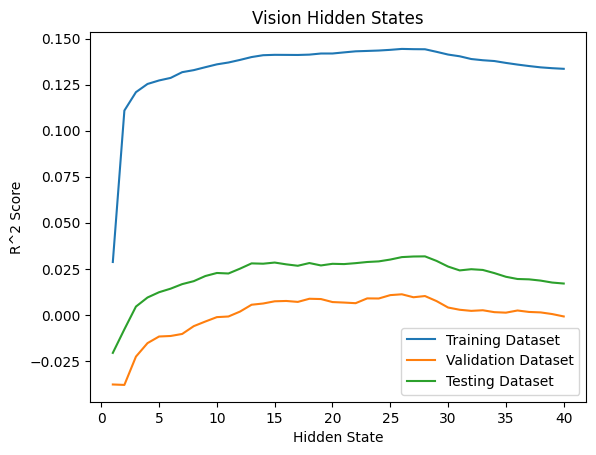

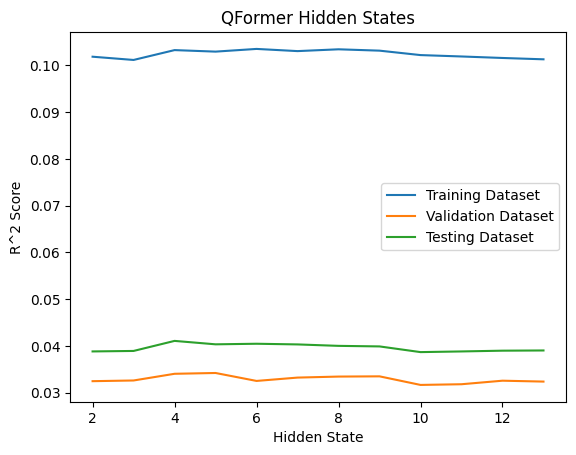

In [47]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(vision_x, vision_trn_y, label="Training Dataset")
plt.plot(vision_x, vision_val_y, label="Validation Dataset")
plt.plot(vision_x, vision_tst_y, label="Testing Dataset")
plt.title("Vision Hidden States")
plt.xlabel("Hidden State")
plt.ylabel("R^2 Score")
plt.legend()
plt.show()

plt.figure()
plt.plot(qformer_x[1:], qformer_trn_y[1:], label="Training Dataset")
plt.plot(qformer_x[1:], qformer_val_y[1:], label="Validation Dataset")
plt.plot(qformer_x[1:], qformer_tst_y[1:], label="Testing Dataset")
plt.title("QFormer Hidden States")
plt.xlabel("Hidden State")
plt.ylabel("R^2 Score")
plt.legend()
plt.show()